## Assessing the isolation window

In [1]:
from ms2_matching import MZMLFile

In [4]:
mzml_file_name = '/Users/simon/git/pymzm/purity/iapi_test_purity.mzML'

In [5]:
mzml_file = MZMLFile(mzml_file_name)

Loaded 403 scans


In [7]:
print(mzml_file.scans[13].ms_level)

1


In [8]:
pre_mz = 79.066

In [167]:
# find the blocks automatically
# and store their starting positions (i.e. the MS1 before the first MS2)
pos = 0
starting_positions = []
while True:
    if mzml_file.scans[pos].ms_level == 2:
        starting_positions.append(pos-1)
        pos += 9
    else:
        pos += 1
    if pos >= len(mzml_file.scans):
        break

In [188]:
def get_scan_idx(start_pos):
    return range(start+1,start+10,2)
def get_target_mz(ms2_scans):
    target_mz = []
    for s_idx in ms2_scans:
        scan = mzml_file.scans[s_idx]
        assert scan.ms_level == 2
        target_mz.append(scan.precursor_mz)
    return target_mz
def find_original_precursor(first_ms1_scan,target_mz):
    sub_peaks = list(filter(lambda x: x[0]>=min(target_mz) and x[0] <= max(target_mz),first_ms1_scan.peaks))
    mz,intensity = zip(*sub_peaks)
    intensity = np.array(intensity)
    pos = np.argmax(intensity)
    original_precursor = mz[pos]
    return original_precursor

In [194]:
import numpy as np

In [305]:

def get_frag_dat(ms2_scans):
    import numpy as np
    frag_dat = []
    frag_idx = {}
    frag_pos = 0
    n_dp = 2
    for i,s_idx in enumerate(ms2_scans):
        scan = mzml_file.scans[s_idx]
        for mz,intensity in scan.peaks:
            round_mz = round(mz,n_dp)
            if not round_mz in frag_idx:
                frag_idx[round_mz] = frag_pos
                frag_pos += 1
            frag_dat.append((frag_idx[round_mz],i,intensity))
    frag_mat = np.zeros((len(frag_idx),len(ms2_scans)))
    for i,j,k in frag_dat:
        frag_mat[i,j] += k
    return frag_mat,frag_idx

In [332]:
def filter_frags(frag_mat,frag_idx,min_count = 5,min_intensity = 1e7):
    # only keep fragments in all scans
    ma = frag_mat.max(axis=1)
    pos = np.where(((frag_mat>0).sum(axis=1) >= min_count)* (ma > min_intensity))[0]
    new_mat = np.zeros((len(pos),len(ms2_scans)))
    new_idx = {}
    reverse_idx = {v:k for k,v in frag_idx.items()}
    new_pos = 0
    for p in pos:
        frag = reverse_idx[p]
        new_idx[frag] = new_pos
        new_mat[new_pos,:] = frag_mat[p,:]
        new_pos += 1
    new_reverse = {v:k for k,v in new_idx.items()}
    return new_mat,new_idx,new_reverse

In [395]:
all_mats = None

min_pre = 56
max_pre = 58

for start in starting_positions:
    ms2_scans = get_scan_idx(start)
    if start < 10:
        continue
    try:
        target_mz = get_target_mz(ms2_scans)
    except:
        break
        
    
    original_precursor = find_original_precursor(mzml_file.scans[start],target_mz)
    
    if original_precursor < min_pre or original_precursor > max_pre:
        continue
    

    frag_mat,frag_idx = get_frag_dat(ms2_scans)
    frag_mat,frag_idx,reverse_idx = filter_frags(frag_mat,frag_idx,min_count = 2,min_intensity = 0)

    
    # row normalise...each peak has max intensity 1
    ma = frag_mat.max(axis=1)
    frag_mat /= ma[:,None]
    
    # sort by pre_mz
    sort_idx = np.argsort(target_mz)
    
    
    if all_mats is None:
        all_mats = frag_mat[:,sort_idx]
    else:
        all_mats = np.vstack((all_mats,frag_mat[:,sort_idx]))

In [396]:
print(all_mats)

[[0.         0.         0.88184228 1.         0.90184661]
 [0.         0.         0.         0.968043   1.        ]
 [0.         0.         0.         1.         0.93691942]]


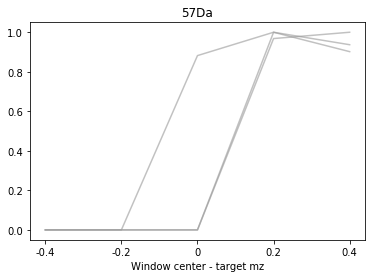

In [398]:
p = plt.plot(all_mats.T,'k',color=[0.6,0.6,0.6,0.6])
plt.xticks(range(0,5),[-0.4,-0.2,0,0.2,0.4])
plt.xlabel('Window center - target mz')
plt.title('57Da')
plt.savefig('example.png')


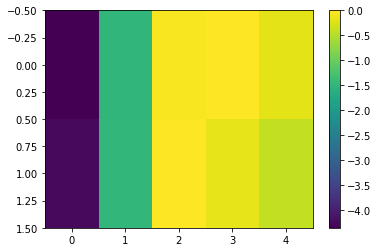

In [374]:
plt.imshow(np.log(frag_mat[:,sort_idx]+1e-5),aspect='auto')
plt.colorbar()

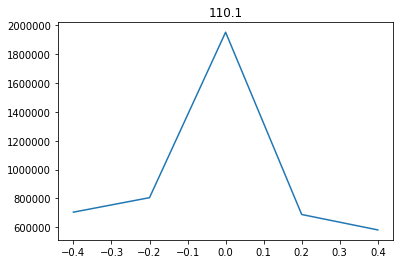

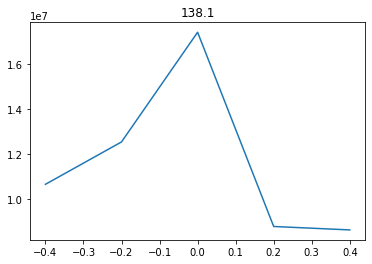

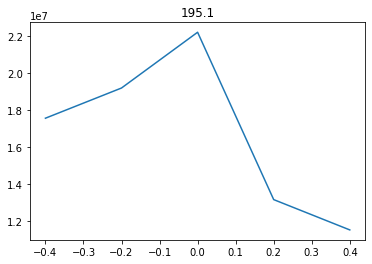

In [166]:
# the first few are in all spec -- plot them
for i,row in enumerate(new_mat):
    plt.figure()
    plt.plot(np.array(target_mz)[sort_idx] - original_precursor,(row[sort_idx]))
    plt.title(new_reverse[i])

In [318]:
start = 27
for i in range(5):
    t0 = 60*mzml_file.scans[start+2*i-1].rt_in_minutes
    t1 = 60*mzml_file.scans[start+2*i].rt_in_minutes
    t2 = 60*mzml_file.scans[start+1+2*i].rt_in_minutes
    delta1 = t1-t0
    delta2 = t2-t1
    previous1 = mzml_file.scans[start+2*i-1].ms_level
    previous2 = mzml_file.scans[start+2*i].ms_level
    print("MS1:{:.3f} Delta = {:.3f} (MS{})".format(t1,delta1,previous1))
    print("MS2:{:.3f} Delta = {:.3f} (MS{})".format(t2,delta2,previous2))



MS1:31.853 Delta = 1.017 (MS1)
MS2:32.868 Delta = 1.015 (MS1)
MS1:33.098 Delta = 0.231 (MS2)
MS2:34.113 Delta = 1.015 (MS1)
MS1:34.344 Delta = 0.231 (MS2)
MS2:35.364 Delta = 1.019 (MS1)
MS1:35.590 Delta = 0.227 (MS2)
MS2:36.604 Delta = 1.014 (MS1)
MS1:36.830 Delta = 0.226 (MS2)
MS2:37.845 Delta = 1.015 (MS1)


In [312]:
print(target_mz)

[194.687646484375, 194.887646484375, 195.087646484375, 195.287646484375, 195.487646484375]


In [313]:
print([t-original_precursor for t in target_mz])

[-0.3999542236328182, -0.19995422363280113, 4.57763671875e-05, 0.20004577636717613, 0.4000457763671932]
